## 第四章 评估方法和各种数据的处理

### 4.1 评估方法
#### 有监督学习的评估
如 1.2 节所述，有监督学习有多种评估模型的指标。第 2 章和第 3 章介绍了许多机器学习算法，
我们现在应该已经知道了每种算法的特点，以及如何为数据集选择合适的算法。本节将梳理一下有
监督学习的常见的评估方法、提高机器学习性能的方法，以及提高性能时的障碍。
在评估有监督学习的分类问题和回归问题时，所需的指标不同（表 4-1）。

![](image/label4-1.png)

下面就让我们看一下各个指标的含义，学会为要解决的问题选择合适的指标。
在介绍如何评估有监督学习之后，本节还将介绍防止过拟合的方法，以及选择超参数的方法。
过拟合是使用机器学习时绕不开的问题。即使选择了正确的评估指标，但是如果在训练数据上发生
了过拟合，也无法创建一个好的模型。有几种方法可以防止过拟合，本节将重点介绍一种叫作交叉
验证的技术。

#### 分类问题的评估方法
下面我们来看一下分类问题的评估方法。
1.2 节中有一段使用逻辑回归模型对美国威斯康星州乳腺癌数据集进行机器学习的代码。
大家可以回到 1.2 节看一下数据的详细信息 。
需要注意的是，这里把目标变量（类别标签数据）的 0 和 1 反转了。这是为了将恶性视为 1
（阳性），将良性视为 0（阴性）。在 scikit-learn 中，标签往往没有意义。这个数据本来是将恶性视为
0 的，但是在实际的诊疗中，一般将发现恶性肿瘤作为检查目标，所以就这个问题来说，把恶性当
作阳性来处理更加自然。

In [3]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = 1 - data.target
# 反转标签的0和1
X = X[:, :10]
from sklearn.linear_model import LogisticRegression
model_lor = LogisticRegression(solver='lbfgs', max_iter=1000)
model_lor.fit(X, y)
y_pred = model_lor.predict(X)

#### 混淆矩阵
首先要介绍的分类问题评估指标是**混淆矩阵**（confusion matrix）。
如果我们用的是个二分类的模型，那么把预测情况与实际情况的所有结果两两混合，结果就会出现以下4种情况，就组成了混淆矩阵。

![](./image/ConfusionMatrix.png)

由于1和0是数字，阅读性不好，所以我们分别用P和N表示1和0两种结果。变换之后为PP，PN，NP，NN，阅读性也很差，我并不能轻易地看出来预测的正确性与否。因此，为了能够更清楚地分辨各种预测情况是否正确，我们将其中一个符号修改为T和F，以便于分辨出结果。

- P（Positive）： 代表1

- N（Negative）： 代表0

- T（True）： 代表预测正确

- F（False）： 代表错误

按照上面的字符表示重新分配矩阵，混淆矩阵就变成了下面这样：

![](./image/ConfusionMatrix2.png)

将这种表示方法总结如下，可分为两部分：

![](./image/ConfusionMatrix3.png)

因此对于这种表示方法可以这么简单的理解：先看 ①预测结果（P/N），再根据②实际表现对比预测结果，给出判断结果（T/F）。 按这个顺序理解，这四种情况就很好记住了。

TP： 预测为1，预测正确，即实际1

FP： 预测为1，预测错误，即实际0

FN： 预测为0，预测错确，即实际1

TN： 预测为0，预测正确即，实际0

混淆矩阵可以将分类结果以
表格的形式汇总，这样就可以检查哪些标签分类正确，哪些标签分类错误。我们可以通过 scikit-
learn 的 confusion_matrix 函数创建混淆矩阵。

In [4]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred)
print(cm)

[[337  20]
 [ 30 182]]


将这个二元分类的结果作为混淆矩阵输出，我们会得到一个 2 行 2 列的矩阵。如表 4-2 所示，它是一个真实数据（正确答案）和预测数据的矩阵。

![](image/label4-2.png)

- 左上角的 TN （True Negative）指的是阴性数据实际被正确预测为阴性的情况（正确判断为良性）。
- 右上角的 FP （False Positive）指的是阴性数据实际被错误地预测为阳性的情况（良性被判断为恶性）。
- 左下角的 FN （False Negative）指的是阳性数据实际被错误地预测为阴性的情况（恶性被判断为良性）。
- 右下角的 TP （True Positive）指的是阳性数据实际被正确预测为阳性的情况（正确判断为恶性）。
结合输出的数据可知，TN 有 341 条，TP 有 176 条，FP 有 16 条，FN 有 36 条。正确预测的
TN、TP 的值较大，总体良好。但是，有 36 条 FN 出现，说明有 36 个恶性患者被漏诊。再看一下
相反的情况，FP 有 16 条，说明模型将 16 条良性患者预测为恶性了。
这一点可以通过观察后面即将介绍的召回率（recall）再次得到证实。如果想避免恶性患者被漏
诊，可以通过后面即将介绍的预测概率来调整预测。
混淆矩阵由 4 个数值组成，作为评估指标使用可能让人比较难以理解。因此，有时我们会使用
混淆矩阵中的元素计算其他数值，并将其作为评估指标。经常使用的指标有以下几个。

![](image/math4-1.png)

具体使用哪些指标取决于使用目的。为了正确判断对给定的问题使用哪个指标，我们需要了解
每个指标的含义。下面来详细看一下各个指标。

#### 正确率
**正确率**（accuracy）指的是预测正确的结果占总预测结果的比例。
其公式如下：

准确率=(TP+TN)/(TP+TN+FP+FN)

![](./image/accuracy.png)

虽然准确率可以判断总的正确率，但是在样本不平衡 的情况下，并不能作为很好的指标来衡量结果。举个简单的例子，比如在一个总样本中，正样本占90%，负样本占10%，样本是严重不平衡的。对于这种情况，我们只需要将全部样本预测为正样本即可得到90%的高准确率，但实际上我们并没有很用心的分类，只是随便无脑一分而已。这就说明了：由于样本不平衡的问题，导致了得到的高准确率结果含有很大的水分。即如果样本不平衡，准确率就会失效。

正因为如此，也就衍生出了其它两种指标：精准率和召回率。
accuracy_score 函数用于计算正确率。

In [5]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)

0.9121265377855887

这里输出的是基于“作为实际答案的目标变量 y”和“使用学习后的模型预测的 y_pred”计算出来的正确率。
正确率超过了 90%，看上去模型正确地学习了数据。

#### 精确率
**精确率**（precision）指的是在所有被预测为阳性的数据中，被正确预测为阳性的数据所占的比例。
它是针对预测结果 而言的，它的含义是在所有被预测为正的样本中实际为正的样本的概率，意思就是在预测为正样本的结果中，我们有多少把握可以预测正确，其公式如下：

精准率=TP/(TP+FP)

![](./image/precision.png)

> 精准率和准确率看上去有些类似，但是完全不同的两个概念。精准率代表对正样本结果中的预测准确程度，而准确率则代表整体的预测准确程度，既包括正样本，也包括负样本。

precision_score 函数用于计算精确率。

In [6]:
from sklearn.metrics import precision_score
precision_score(y, y_pred)

0.900990099009901

与正确率的计算一样，精确率是基于 y 和 y_pred 计算出来的。在这个问题中，它表示预测为恶性的病例中实际确实为恶性的病例所占的比例。精确率低，意味着预测为恶性的病例之中包含了其实是良性的病例。在这种情况下，可以通过再次检查等方式解决精确率低的问题。

#### 召回率
召回率指的是在实际为阳性的数据中，被正确预测为阳性的数据所占的比例。是针对原样本而言的，它的含义是在实际为正的样本中被预测为正样本的概率，其公式如下：

精准率=TP/(TP+FN)

![](./image/recall.png)

recall_score函数用于计算召回率。

In [7]:
from sklearn.metrics import recall_score
recall_score(y, y_pred)

0.8584905660377359

与正确率的计算一样，召回率是基于 y 和 y_pred 计算出来的。在这个问题中，它表示实际为恶性的病例中被正确地预测为恶性的病例所占的比例。召回率低，意味着实际为恶性的病例大部分被预测为良性。与精确率低的情况相比，召回率低的问题更严重。在使用这样的模型解决实际问题之前，需要想办法提高召回率。后面的“预测概率”部分将介绍如何提高召回率。

#### F值
**F 值**是综合反映精确率和召回率两个趋势的指标。如果我们把精确率（Precision）和召回率（Recall）之间的关系用图来表达，就是下面的PR曲线：

![](./image/F1.png)

可以发现他们俩的关系是「两难全」的关系。为了综合两者的表现，在两者之间找一个平衡点，就出现了一个 F1分数。

F1=(2×Precision×Recall)/（Precision+Recall）

f1_score 函数用于计算 F 值。

In [8]:
from sklearn.metrics import f1_score
f1_score(y, y_pred)

0.8792270531400966

精确率和召回率之间是此消彼长的关系，如果试图让其中一个的值更高，则会导致另一个的值
更低。如果这两个指标同等重要，可以观察 F 值。

#### 预测概率
到目前为止，我们都是使用 predict 进行标签预测的。接下来我们看一下预测概率。在进行
二元分类时，预测结果必须为 0 或者 1 这两个值中的一个。然而，实际情况是大多数模型预测的是
数据被分类为某一个标签的概率。也就是说，我们可以分别求出数据被分类为 0 或 1 的概率。
我们可以使用学习后的模型的 predict_proba 方法查看预测概率。

In [ ]:
model_lor.predict_proba(X)

上面的代码输出的是特征 X 中每个数据被预测为 0 或 1 的概率。以第一行为例，数据被分类
为 0 的概率约为 0.44%，所以预测其为恶性（1）。相反，最后一行的数据被分类为 0 的概率约为
97.4%，所以预测其为良性（0）。
另外，scikit-learn 的 predict 方法使用的是基于阈值 0.5 输出的判断结果。
为了尽量避免漏掉恶性病例，我们考虑预测概率的第 2 个元素（即恶性的概率）为 10%（0.1）
或更大的情况。

In [11]:
import numpy as np
y_pred2 = (model_lor.predict_proba(X)[:, 1]>0.1).astype(int)
print(confusion_matrix(y, y_pred2))

[[267  90]
 [  6 206]]


在输出混淆矩阵后，和我们设想的一样，左下角的 FN（实际为 1 却被错误地预测为 0 的数据）
减少了。
这里再看一下其他指标。

In [12]:
print(accuracy_score(y, y_pred2))
print(recall_score(y, y_pred2))

0.8312829525483304
0.9716981132075472


正确率下降到 0.82 左右，但是恶性（1）病例的召回率非常高，达到了 0.99 左右。

#### ROC 曲线与 AUC
现在我们已经了解了正确率和 F 值等指标，但实际上在有些情况下，这些指标并不能很好地发
挥作用。这些情况发生在阳性数据的数量和阴性数据的数量有很大偏差的时候。假设有一个总是预
测输出结果为阳性的模型。由于对任何输入都预测数据是阳性的，所以我们可能会以为这个模型的
正确率非常低。但在输入数据有偏差的情况下，比如阳性数据有 95 个，阴性数据有 5 个的情况下，
正确率会高达 95%。
虽然这个模型是一个极端的例子，但是在实际工作中，这种没有经过很好训练的模型因数据不
均衡而计算出高正确率结果的情况经常出现。
应对数据不均衡问题的指标有 AUC （Area Under the Curve，曲线下面积）。AUC 指的是 ROC
（Receiver Operating Characteristic，接收器操作特性）曲线下的面积。

**灵敏度，特异度，真正率，假正率**

在正式介绍 ROC/AUC 之前，我们还要再介绍两个指标，这两个指标的选择也正是 ROC 和 AUC 可以无视样本不平衡的原因。 这两个指标分别是：灵敏度和（1- 特异度），也叫做真正率（TPR）和假正率（FPR）。

灵敏度（Sensitivity） = TP/(TP+FN)

特异度（Specificity） = TN/(FP+TN)

- 其实我们可以发现灵敏度和召回率是一模一样的，只是名字换了而已。
- 由于我们比较关心正样本，所以需要查看有多少负样本被错误地预测为正样本，所以使用（1- 特异度），而不是特异度。

真正率（TPR） = 灵敏度 = TP/(TP+FN)

假正率（FPR） = 1- 特异度 = FP/(FP+TN)

下面是真正率和假正率的示意，我们发现TPR 和 FPR 分别是基于实际表现 1 和 0 出发的，也就是说它们分别在实际的正样本和负样本中来观察相关概率问题。 正因为如此，所以无论样本是否平衡，都不会被影响。还是拿之前的例子，总样本中，90% 是正样本，10% 是负样本。我们知道用准确率是有水分的，但是用 TPR 和 FPR 不一样。这里，TPR 只关注 90% 正样本中有多少是被真正覆盖的，而与那 10% 毫无关系，同理，FPR 只关注 10% 负样本中有多少是被错误覆盖的，也与那 90% 毫无关系，所以可以看出：如果我们从实际表现的各个结果角度出发，就可以避免样本不平衡的问题了，这也是为什么选用 TPR 和 FPR 作为 ROC/AUC 的指标的原因。

![](./image/TFPR.png)

或者我们也可以从另一个角度考虑：条件概率。 我们假设X为预测值，Y为真实值。那么就可以将这些指标按条件概率表示：

精准率 = P（Y=1 | X=1）

召回率 = 灵敏度 = P（X=1 | Y=1）

特异度 = P（X=0 | Y=0）

从上面三个公式看到：如果我们先以实际结果为条件（召回率，特异度），那么就只需考虑一种样本，而先以预测值为条件（精准率），那么我们需要同时考虑正样本和负样本。所以先以实际结果为条件的指标都不受样本不平衡的影响，相反以预测结果为条件的就会受到影响。

**ROC（接受者操作特征曲线）**

> ROC（Receiver Operating Characteristic）曲线，又称接受者操作特征曲线。该曲线最早应用于雷达信号检测领域，用于区分信号与噪声。后来人们将其用于评价模型的预测能力，ROC 曲线是基于混淆矩阵得出的。

ROC 曲线中的主要两个指标就是真正率和假正率， 上面也解释了这么选择的好处所在。其中横坐标为假正率（FPR），纵坐标为真正率（TPR），下面就是一个标准的 ROC 曲线图。

![](./image/ROC.png)

**ROC 曲线的阈值问题**
与前面的 P-R 曲线类似，ROC 曲线也是通过遍历所有阈值 来绘制整条曲线的。如果我们不断的遍历所有阈值，预测的正样本和负样本是在不断变化的，相应的在 ROC 曲线图中也会沿着曲线滑动。

![](./image/ROCm.gif)

**如何判断 ROC 曲线的好坏？**

改变阈值只是不断地改变预测的正负样本数，即 TPR 和 FPR，但是曲线本身是不会变的。那么如何判断一个模型的 ROC 曲线是好的呢？这个还是要回归到我们的目的：FPR 表示模型虚报的响应程度，而 TPR 表示模型预测响应的覆盖程度。我们所希望的当然是：虚报的越少越好，覆盖的越多越好。所以总结一下就是TPR 越高，同时 FPR 越低（即 ROC 曲线越陡），那么模型的性能就越好。 参考如下：

![](./image/ROCm2.gif)

**ROC 曲线无视样本不平衡**

前面已经对 ROC 曲线为什么可以无视样本不平衡做了解释，下面我们用动态图的形式再次展示一下它是如何工作的。我们发现：无论红蓝色样本比例如何改变，ROC 曲线都没有影响。

![](./image/ROCm3.gif)

**AUC（曲线下的面积）**

为了计算 ROC 曲线上的点，我们可以使用不同的分类阈值多次评估逻辑回归模型，但这样做效率非常低。幸运的是，有一种基于排序的高效算法可以为我们提供此类信息，这种算法称为曲线下面积（Area Under Curve）。

比较有意思的是，如果我们连接对角线，它的面积正好是 0.5。对角线的实际含义是：随机判断响应与不响应，正负样本覆盖率应该都是 50%，表示随机效果。 ROC 曲线越陡越好，所以理想值就是 1，一个正方形，而最差的随机判断都有 0.5，所以一般 AUC 的值是介于 0.5 到 1 之间的。

AUC 的一般判断标准

0.5–0.7： 效果较低，但用于预测股票已经很不错了

0.7–0.85： 效果一般

0.85–0.95： 效果很好

0.95–1： 效果非常好，但一般不太可能

**AUC 的物理意义**

曲线下面积对所有可能的分类阈值的效果进行综合衡量。曲线下面积的一种解读方式是看作模型将某个随机正类别样本排列在某个随机负类别样本之上的概率。以下面的样本为例，逻辑回归预测从左到右以升序排列


![](./image/image4-1.png)

这里的 ROC 曲线（图 4-1）指
的是横轴为假阳性率（即 FP 的占比），纵轴为真阳性率（即 TP 的占比）的图形。图中显示了当预
测数据为阳性的预测概率的阈值从 1 开始逐渐下降时，FP 和 TP 之间关系的变化。
假阳性率、真阳性率是可视化 ROC 曲线的必要条件，可以使用 roc_curve 函数计算。

In [13]:
from sklearn.metrics import roc_curve
probas = model_lor.predict_proba(X)
fpr, tpr, thresholds = roc_curve(y, probas[:, 1])

roc_curve 函数的输入是目标变量（类别标签数据）和预测概率。这里使用 predict_
proba 方法计算了预测概率。下面在 Matplotlib 中对 roc_curve 函数输出的 fpr 和 tpr 进行可
视化。

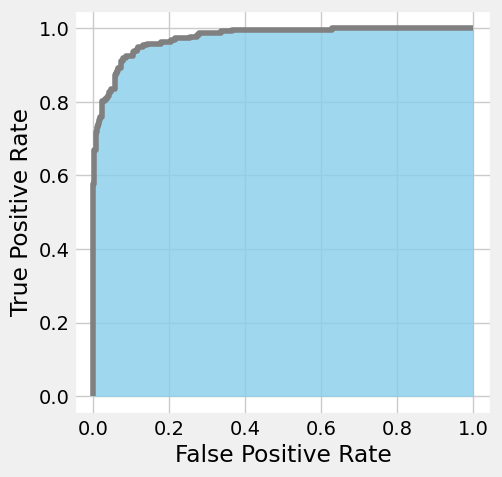

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
fig.set_size_inches(4.8, 5)
ax.step(fpr, tpr, 'gray')
ax.fill_between(fpr, tpr, 0, color='skyblue', alpha=0.8)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_facecolor('xkcd:white')
plt.show()

ROC 曲线下方的面积是 AUC。面积的最大值是 1，最小值是 0。AUC 越接近于 1（面积越大），
说明精度越高；如果其值在 0.5 左右，则说明预测不够理想。换言之，如果值在 0.5 左右，则得到
的分类模型和抛硬币随机决定良性恶性没多大区别。
roc_auc_score 函数用于计算 AUC 值。

In [15]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y, probas[:, 1])

0.9741028486866444

AUC 的结果约为 0.977，接近于 1。对于一个分类模型来说，这样的精度是很高的。
由于乳腺癌的数据偏差不大，所以用正确率来考查模型的性能也没有太大问题。不过如果输入
数据为关于“观看网站广告的用户中有多少会购买商品”的预测数据，那么正例和反例的数量可能
有相当大的偏差，常常出现正确率为 0.99，但 AUC 只有 0.6 的情况。在处理不均衡数据时，我们使
用 AUC 作为指标。

#### 回归问题的评估方法


接下来介绍回归问题的评估方法。由于回归问题的目标是预测大小关系有意义的值，所以有些
评估方法和分类问题的评估方法不同。这里使用的数据是美国波士顿的房价数据集。这个数据集有
13 个特征变量，目标变量是 5.0 ～ 50.0 的数值。简单起见，这里介绍一元回归的评估方法，所以我
们只使用 13 个特征变量中的“住宅平均房间数”（列名为 RM）。

In [ ]:
from sklearn.datasets import load_boston
data = load_boston()
X = data.data[:, [5,]]
y = data.target

这里设从数据集中的特征变量选择的平均房间数的列为 X，目标变量为 y。虽然特征变量 X 是
由一列组成的数据，但这里也按照惯例使用大写的 X。目标变量 y 是数值数据。X 是 506 行 1 列的
数据，y 也是 506 行 1 列的数据。

In [ ]:
from sklearn.linear_model import LinearRegression
model_lir = LinearRegression()
model_lir.fit(X, y)
y_pred = model_lir.predict(X)

上面的代码导入并使用了 LinearRegression 类，然后初始化 model_lir，使用 fit 方法
进行训练。接着，代码使用训练好的 model_lir 的 predict 方法进行预测，并将预测结果赋给
变量 y_pred。
本次使用的 LinearRegression 是一种线性回归算法。另外，由于特征变量是 1 列数据，所
以模型可以使用线性方程 y = ax + b 表示。现在看一下斜率 a 和截距 b 的值。

In [ ]:
print(model_lir.coef_)
print(model_lir.intercept_)

斜率 a 约为 9.10,截距 b 约为 -34.67,所以本次训练的模型可以表示为直线 y = 9.10x - 34.67。
当房间数为 5 时，将其代入该式，有 9.10×5 - 34.67，可以得到预测租金为 10.83。线性回归利用训
练数据确定学习参数 a 和 b。随着训练数据的增减，这些学习参数会变为不同的值。
接下来绘制预测结果的图形，来看一下训练好的模型是如何预测的。由于这次是基于一个特征
变量（平均房间数）对目标变量（租金）进行预测的，所以我们可以绘制一个横轴为平均房间数，
纵轴为租金的图形。
下面使用 Matplotlib 查看数据。

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X, y, color='pink', marker='s', label='data set')
ax.plot(X, y_pred, color='blue', label='LinearRegression')
ax.legend()
plt.show()

图 4-2 中数据集的颜色是粉红色。从粉红色的数据来看，图形的右上角包含了离群值（在图形
顶部绘制的纵轴值为 50 的数据）。蓝线代表预测结果，与数据基本一致。这是一个预测房价会随着
房间数量的增加而上涨的一次函数。通过可视化，我们能够大致了解学习结果。接下来使用均方误
差和决定系数这两个指标来量化学习结果。

![](image/image4-2.png)

### 均方误差
平方误差是一个表示实际值和预测值之间存在多大差异的数值。下面结合例子来说明，请看
图 4-3。

![](image/image4-3.png)

图中的直线表示预测值，直线上有以 × 标记的点 和 。从每个点出发，分别朝着表示预测
值的直线画一条线段作为辅助线，辅助线的长度就是误差。
从图中可以看出，1
比2
离预测值更远。也就是说，2
更接近预测值，误差更小。对于要评
估的数据，计算所有预测值与数据之间的误差的平方，并取平方的平均值，得到的就是均方误差
（Mean-Square Error，MSE）。换言之，均方误差越小，预测效果越好。我们可以使用 scikit-learn 提
供的 mean_squared_error 函数计算均方误差。

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y, y_pred)

均方误差约为 43.6。

### 决定系数
**决定系数**（coefficient of determination）是使用均方误差来表示训练好的模型的预测效果的数
值，也就是被称为 R 2 的系数。
当该系数取最大值 1.0 时，说明没有误差。它的值通常在 0.0 和 1.0 之间，但如果预测的误差过
大，也可能为负值。换言之，该系数的值越接近 1.0，说明模型对数据点的解释能力越强。我们可
以使用 r2_score 函数计算决定系数。

In [ ]:
from sklearn.metrics import r2_score
r2_score(y, y_pred)

决定系数约为 0.484。

### 均方误差和决定系数指标的不同
前面解释了如何使用均方误差和决定系数两个指标评估回归问题。光看均方误差的数值不能判
断精度是好还是坏。如果目标变量的方差较大，均方误差也会变大。而决定系数可以使用不依赖于
目标变量方差的取值范围在 0.0 和 1.0 之间的值表示，所以即使目标变量的数量级不同，也可以将
决定系数作为一般的指标使用。

### 与其他算法进行比较
前面使用 LinearRegression 介绍了均方误差和决定系数，我们再来看一下使用其他算法的
情况。下面使用 SVR 进行回归，并与使用 LinearRegression 时的情况进行比较。
SVR 是将第 2 章介绍的支持向量机（核方法）应用于回归而得到的算法。

In [ ]:
from sklearn.svm import SVR
model_svr_linear = SVR(C=0.01, kernel='linear')
model_svr_linear.fit(X, y)
y_svr_pred = model_svr_linear.predict(X)

上面的代码导入了 SVR 类，用于训练和预测。下面在图 4-4 中查看使用 LinearRegression
和 SVR 时的学习结果。

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X, y, color='pink', marker='s', label='data set')
ax.plot(X, y_pred, color='blue', label='LinearRegression')
ax.plot(X, y_svr_pred, color='red', label='SVR')
ax.legend()
plt.show()

![](./image/image4-4.png)

蓝线表示 LinearRegression，红线表示 SVR。从图中可以看出，SVR 的线和数据不太一
致。下面看一下均方误差和决定系数的值。

In [ ]:
print(mean_squared_error(y, y_svr_pred))
print(r2_score(y, y_svr_pred))
print(model_svr_linear.coef_)
# 决定系数
# 斜率
print(model_svr_linear.intercept_)
# 截距

结果依次是均方误差、决定系数、斜率和截距。LinearRegression 的均方误差和决定系数
分别约为 43.6 和 0.484，与之相比，SVR 的均方误差和决定系数都变差了，分别约为 72.1 和 0.145。
经过比较，我们发现 LinearRegression 的各个指标的值都更好。
通过均方误差和决定系数，我们能够对模型进行定量评估。这个结果可能会给人以 SVR 不是
一个好算法的印象。其实通过改变 SVR 的 C 和 kernel 参数，就可以改善 SVR 的均方误差和决定
系数。

### 超参数的设置
下面将初始化 SVR 时的参数变更为 C = 1.0, kernel = 'rbf'。

In [ ]:
model_svr_rbf = SVR(C=1.0, kernel='rbf')
model_svr_rbf.fit(X, y)
y_svr_pred = model_svr_rbf.predict(X)
print(mean_squared_error(y, y_svr_pred))
print(r2_score(y, y_svr_pred))
# 决定系数
# 均方误差

可以看出，均方误差和决定系数都得到了改善。C 和 kernel 是 SVR 的超参数。model_svr_
rbf.coef_ 和 model_svr_rbf.intercept_ 等学习参数是由机器学习算法更新的，而超参数
需要在训练开始前由用户给出。因此，如果超参数设置得不好，模型的性能就可能会很差。

### 模型的过拟合
下面来看一下模型的过拟合。
使用以下代码将数据集分为训练数据和用来确认性能的验证数据，然后进行 S V R 的训练和
预测。

In [ ]:
train_X, test_X = X[:400], X[400:]
train_y, test_y = y[:400], y[400:]
model_svr_rbf_1 = SVR(C=1.0, kernel='rbf')
model_svr_rbf_1.fit(train_X, train_y)
test_y_pred = model_svr_rbf_1.predict(test_X)
print(mean_squared_error(test_y, test_y_pred))
print(r2_score(test_y, test_y_pred))
# 决定系数
# 均方误差

虽然超参数没有变过，但模型在验证数据上的表现远差于在训练数据上的表现。这种对训练数
据的预测效果很好，但对验证数据（没有用于训练的数据）的预测效果不好的现象叫作过拟合。
在有监督学习中，防止过拟合是一个重要课题。仅仅考查之前介绍的各指标，并不足以判断模
型的好坏。重要的是在解决实际问题时，模型对未知数据的预测精度。模型对这种未知数据的预测
能力叫作泛化能力。即使模型对训练数据的均方误差很小，如果发生过拟合，泛化能力也会很低。
过拟合和超参数的设置是分类问题和回归问题的共同挑战。接下来本书将讨论如何应对这些
挑战。

### 防止过拟合的方法
有监督学习的特征值和目标变量是作为训练数据预先给出的。前面介绍了对训练数据的性能评
估方法。但在使用有监督学习解决实际问题时，除了评估模型对训练数据的性能之外，评估模型对
不包括在训练数据中的数据（未知数据）的性能也是非常重要的。以乳腺癌数据集为例，“患者的身体数据”（特征）和“恶性 / 良性”（目标变量）是训练数据。
在实际应用中，对于“恶性 / 良性”不明的患者，重要的是能否通过患者的体检数据预测出
“恶性 / 良性”
。一个模型如果对训练数据的预测精度很高，但对未知数据不能进行很好的预测，那
就不能说它是一个好模型。防止过拟合的方法有几种，以下是一些有代表性的方法。

### 将数据分为训练数据和验证数据
防止过拟合的一个代表性的方法是将数据分为训练数据和验证数据。换言之，这种方法不使用
事先给定的所有数据进行训练，而是留出一部分数据用于验证，不用于训练。
使用 scikit-learn 的 train_test_split 函数，我们可以很容易地分割数据。

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

- 训练用的特征值： X_train
- 验证用的特征值： X_test
- 训练用的目标变量： y_train
- 验证用的目标变量： y_test
我们将数据分为训练数据和验证数据，其中 70% 用于训练，30% 用于验证（图 4-5）。这个分
割比例设为多少是没有明确规定的。如果数据集很大，有足够的数据用于训练，将分割比例设置为
6∶4 也是可行的；反之，如果数据集太小，不能很好地进行训练，可以将分割比例设置为 8∶2 等。
另外要注意的是，每次运行时 train_test_split 的结果都是不同的，如果想保持结果固定，需
要设置 random_state 参数。
![](./image/image4-5.png)
下面使用训练数据和验证数据来进行算法的学习，并创建模型。

In [5]:
from sklearn.svm import SVC
model_svc = SVC()
model_svc.fit(X_train, y_train)
y_train_pred = model_svc.predict(X_train)
y_test_pred = model_svc.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

0.9195979899497487
0.9239766081871345


如果与对训练数据的正确率相比，对验证数据的正确率要低很多，就说明数据发生了过拟合。上
面代码中的模型对未知数据的正确率约为 60%。下面使用另一个模型 RandomForestClassifier
来试一下。

In [3]:
from sklearn.ensemble import RandomForestClassifier
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train, y_train)
y_train_pred = model_rfc.predict(X_train)
y_test_pred = model_rfc.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

1.0
0.9649122807017544


这次虽然对验证数据的正确率依然比对训练数据的低，却是约为 96% 的高正确率。由于模型
对验证数据的正确率也很高，所以可以说防止了过拟合。
从这些模型的结果来看，也许我们应该使用 RandomForestClassifier。在选择模型时，
如果没有分割数据，只看对训练数据的正确率，我们可能会选择 SVC。通过观察对验证数据的正确
率，我们能够避免使用出现了过拟合的模型。

### 交叉验证
即使在将数据分为训练数据和验证数据后进行评估，也依然可能发生过拟合。可以想到的原因是使用的训练数据和验证数据碰巧非常相似。反过来也有可能出现训练数据和验证数据非常不相似
的情况。为了避免这种数据分割的误差，可以使用不同的分割方案进行多次验证，这就是所谓的交
叉验证（cross validation）。
本节以将数据分割 5 次，其中 80% 的数据用于训练，20% 的数据用于验证的情况为例进行说明。
如图 4-6 所示，每次获取不同的 20% 的数据作为验证数据，重复 5 次。在这个例子中，20%
的数据是按分组顺序分别分割的，但在实际应用中，作为验证数据的 20% 的数据是随机抽取的。

![](image/image4-6.png)

以下代码非常轻松地将数据分成了 5 块，即运行 5 次，每次留下 20% 的数据用于训练后的验证。

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True)
model_rfc_1 = RandomForestClassifier()
cross_val_score(model_rfc_1, X, y, cv=cv, scoring='accuracy')

array([0.99122807, 0.96491228, 0.92982456, 0.97368421, 0.95575221])

这时正确率会被输出 5 次。我们可以看到正确率有时很高，有时很低。在选择模型时，需要考
虑所有正确率的均值和方差。
另外，我们也可以输出 F 值的评估结果。
通过将 cross_val_score 函数的 scoring 参数定义为 f1，就可以输出 F 值，代码如下
所示。

In [ ]:
cross_val_score(model_rfc_1, X, y, cv=cv, scoring="f1")

### 搜索超参数
前面介绍了如何使用分割得到的数据来选择不会出现过拟合的模型。如果在此基础上仔细地
选择超参数，就可以进一步提高模型的性能。就像前面在“超参数的设置”部分介绍的那样，通过
反复设置一个超参数并检查其性能，最终可以得到更好的超参数。但是多个超参数的组合数量非常
多，逐一设置每个超参数的过程非常耗时。
本节将介绍搜索超参数的方法。
#### 使用网格搜索选择超参数
网格搜索是一种自动搜索超参数的方法。如图 4-7
所示，这是一种对各个超参数组合进行穷尽搜索的方法。
需要注意的是，要搜索的超参数必须事先确定。
下 面 是 使 用 scikit-learn 的 GridSearchCV 进 行
RandomForestClassifier 超参数搜索的示例代码。
GridSearchCV 一边关注对验证数据的性能，一边执行
超参数的搜索。
首先加载数据。这里要做的是对分类任务进行网格搜索，所以要重新加载美国威斯康星州乳腺癌数据集。

![](./image/image4-7.png)

In [8]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = 1 - data.target
# 反转标签的0和1
X = X[:, :10]

接下来进行网格搜索。

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True)
param_grid = {'max_depth': [5, 10, 15], 'n_estimators': [10, 20, 30]}
model_rfc_2 = RandomForestClassifier()
grid_search = GridSearchCV(model_rfc_2, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [10, 20, 30]},
             scoring='accuracy')

上面的代码为 max_depth 准备了 3 个值，为 n_estimators 也准备了 3 个值，对二者所有
的组合，即 3×3 = 9 种情况进行了评估。下面输出所得到的最好的得分及相应的超参数值。

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)

除了交叉验证外，GridSearchCV 还支持使用 F 值进行评估。修改 GridSearchCV 的评估
方法很简单，将 scoring 参数指定为 f1 即可。

In [ ]:
grid_search = GridSearchCV(model_rfc_2, param_grid, cv=cv, scoring='f1')

#### 专栏 防止过拟合的各种方法
前面介绍了通过调整超参数等来防止过拟合的方法。除此之外，还有其他一些方法可以防止过拟合。
下面列出防止过拟合的主要方法的名称。在应对过拟合时，也可以考虑这些方法。
- 增加训练数据
- 减少特征值
- 正则化
- Early Stopping
- 集成学习

## 文本数据的转换处理
本书之前涉及的机器学习模型的输入都是元素为数值的表格形式的数据。然而，在自然语言处
理领域，我们需要处理不能直接作为输入的文本数据。
本节将介绍两种将文本数据转换为表格数据的方法：一种是基于单词出现次 数的转换；另一种
是基于 tf-idf 的转换（图 4-8）。然后，我们将对转换后的表格形式的数据应用机器学习模型，并比
较它们的结果。

![](./image/image4-8.png)

### 基于单词出现次数的转换
下面介绍基于单词出现次数的转换方法。这是一种通过统计文本中的单词出现次数将文本数据
转化为表格形式的数据的方法。
我们看一下对下列文本数据进行转换的例子。
“This is my car”
“This is my friend”
“This is my English book”
表 4-3 统计了每个文本中各个单词出现的次数。表中的行是文本，列是每个文本中各个单词出
现的次数。如果单词在文本中没有出现，则相应单元格的值为 0。通过这个例子，我们就能理解文
本数据是如何转换为表格形式的数据的。

![](./image/table4-3.png)

通过分析单词出现的次数，我们可以描述出文本的特点。仔细观察各个单词，可以发现每个文
本中都会出现一些常见的单词，也有一些文本特有的单词。比如 This 这个单词是每个文本中都会出
现的常见词，但 car 只在文本 1 中出现，所以可以说它是描述文本的一个重要的单词。
只考虑单词出现次数的做法无须考虑这些单词的重要度，对所有单词都平等地进行计数。下面
将介绍 tf-idf 方法是如何考虑并表示单词的重要度的。
### 基于 tf-idf 的转换
tf-idf 是一种基于 tf（term frequency，词频）和 idf（inverse document frequency，逆文本频率指
数）这两个指标来表示单词在文本中的重要度的方法。
tf 是单词在文本中出现的频率，idf 是一个包含该单词的文本越多，值就越小的值。换言之，像
This 这种出现在许多文本中的单词的 idf 就很小。这两个指标相乘得到的结果叫作 tf-idf。表 4-4 是
对刚才的文本数据计算的 tf-idf 的结果。

![](./image/table4-4.png)

This 和 my 等单词在每个文本中都出现了，所以它们的 tf-idf 值较小，而 car 和 friend 等只在特
定文本中出现的单词的 tf-idf 值则较大。行业术语和专有名词等只在特定文本中出现的词，往往具
有较大的 tf-idf 值，有时能够很好地表示包含这些单词的文本。
### 应用于机器学习模型
下面基于单词出现次数和 tf-idf 将文本数据转换为表格形式的数据，并应用于机器学习模型。
scikit-learn 的 CountVectorizer 可以计算单词出现次数，TfidfVectorizer 可以进行 tf-idf 的转
换。另外，通过 fetch_20newsgroups 获取使用的文本数据，机器学习模型则采用 LinearSVC。


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer、TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.datasets import fetch_20newsgroups
categories = ['misc.forsale', 'rec.autos','comp.graphics', 'sci.med']
remove = ('headers', 'footers', 'quotes')
twenty_train = fetch_20newsgroups(subset='train',
remove=remove,
categories=categories)
twenty_test = fetch_20newsgroups(subset='test',
remove=remove,
categories=categories)
# 训练数据
# 验证数据

这里使用的是前面出现过的 20 Newsgroups 数据集，代码通过 categories 变量明确指定了 4
个主题的数据。
首先将文本数据转换为单词出现次数，然后使用 LinearSVC 学习和预测。得到的模型对验证
数据的正确率约为 0.794。也就是说，我们成功地将文本数据转换为了表格形式的数据，并进行了
有监督学习。

In [ ]:
count_vect = CountVectorizer()
# 单词出现次数
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_test_count = count_vect.transform(twenty_test.data)
model = LinearSVC()
model.fit(X_train_counts, twenty_train.target)
predicted = model.predict(X_test_count)
np.mean(predicted == twenty_test.target)

接下来使用 tf-idf 进行转换，然后以同样的方式进行训练和预测。此时得到的模型的正确率约
为 0.87，比基于单词出现次数进行转换的方法的正确率高。通过 tf-idf，看起来我们很好地抓住了
文本数据的特点。

In [ ]:
tf_vec = TfidfVectorizer()
# tf-idf
X_train_tfidf = tf_vec.fit_transform(twenty_train.data)
X_test_tfidf = tf_vec.transform(twenty_test.data)
model = LinearSVC()
model.fit(X_train_tfidf, twenty_train.target)
predicted = model.predict(X_test_tfidf)
np.mean(predicted == twenty_test.target)

## 图像数据的转换处理
本节将介绍如何处理才能将图像数据作为机器学习的输入数据。这里以灰度图像数据为例进行
说明（图 4-9）
。灰度图像指的是图像中的每个像素只表示亮度的图像。大家可以思考一下，要想把
这样的图像数据作为输入数据，需要进行什么处理呢？

![](./image/image4-9.png)



### 直接将像素信息作为数值使用
一种方法是直接将各像素的信息作为数值使用。表 4-5 是将图像数据转换为向量数据的例子。
如果是简单的图像识别问题，就可以使用这种简单的转换建立一个具有一定精度的模型。

![](./image/table4-5.png)

虽然通过这种转换，可以创建机器学习模型的输入数据，但由于具有二维关系的像素数据被
转换为了一维向量，所以可以说重要的信息被丢弃了。有些模型会在保留图像的二维关系的前提下
直接将其作为输入数据进行处理，比如在图像识别中常用的深度学习使用的就是像素的近邻像素的
信息。
下面是将图像数据转换为向量数据的示例代码。代码中使用第三方 Python 包 Pillow 将图像
（png）数据转换为了向量数据。

In [ ]:
from PIL import Image
import numpy as np
img = Image.open('mlzukan-img.png').convert('L')
width, height = img.size
img_pixels = []
for y in range(height):
    for x in range(width):
# 通过getpixel获取指定位置的像素值
        img_pixels.append(img.getpixel((x,y)))
    print(img_pixels)

### 将转换后的向量数据作为输入来应用机器学习模型
前面介绍了如何将图像数据转换为向量数据，接下来我们尝试实际使用转换后的数据来创建机
器学习模型。这里我们使用灰度手写数字数据建立一个模型，用于预测从 0 到 9 的 10 个数字。
由于 scikit-learn 的 datasets 模块能够获取转换后的向量数据，所以我们使用它来获取输入
数据。
从预测结果来看，使用了向量数据的模型成功地进行了高精度的预测。



In [13]:
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
digits = datasets.load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
model = RandomForestClassifier()
model.fit(data[:n_samples // 2], digits.target[:n_samples // 2])
expected = digits.target[n_samples // 2:]
predicted = model.predict(data[n_samples // 2:])
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        88
           1       0.95      0.90      0.93        91
           2       0.99      0.91      0.95        86
           3       0.92      0.86      0.89        91
           4       0.97      0.91      0.94        92
           5       0.88      0.92      0.90        91
           6       0.97      0.99      0.98        91
           7       0.95      0.98      0.96        89
           8       0.92      0.90      0.91        88
           9       0.83      0.96      0.89        92

    accuracy                           0.93       899
   macro avg       0.93      0.93      0.93       899
weighted avg       0.93      0.93      0.93       899

